### ElasticNet – Fold-Based Evaluation with Separate Train and Test Sets

* **Dataset:** Wind turbine power generation data split into 8 temporal folds using a sliding window approach.
* **Per Fold Workflow:**

  * Use a specific **percentage of the training set** (e.g., 10%, 20%, 70%, 100%) for model training.
  * Evaluate on the **separate, fixed test set** corresponding to the fold.
* **ElasticNet Model:**

  * Hyperparameters (`alpha`, `l1_ratio`) optimized via `GridSearchCV`.
  * Data is preprocessed with `StandardScaler`.

This setup ensures a **fair comparison** between ElasticNet and semi-supervised methods (such as S2RMS) by assessing performance **under limited supervision** using the **same folds, splits, and evaluation criteria**.


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.io import arff

sns.set_theme(style="whitegrid")


In [ ]:
DATA_DIR = "../data/swdpf/arff_scaled_folds"
RESULTS_DIR = "../results/elasticnet_folds"
os.makedirs(RESULTS_DIR, exist_ok=True)

SCALES = [100]
FOLDS = range(8)
TARGET_COL = "patv_target_1"
SEED = 42


In [21]:
def evaluate_elasticnet_on_fold(train_df, test_df, scale, fold):
    scale_ratio = scale / 100 if scale > 1 else scale

    # Shuffle train_df e prendo solo la percentuale indicata per il training
    train_df = train_df.sample(frac=1.0, random_state=SEED+fold).reset_index(drop=True)
    n_train = len(train_df)
    n_labeled = int(n_train * scale_ratio)

    labeled = train_df.iloc[:n_labeled]

    X_train = labeled.drop(columns=[TARGET_COL])
    y_train = labeled[TARGET_COL]

    X_test = test_df.drop(columns=[TARGET_COL])
    y_test = test_df[TARGET_COL]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("elasticnet", ElasticNet(max_iter=10000))
    ])

    param_grid = {
        "elasticnet__alpha": [0.1, 1.0, 10.0],
        "elasticnet__l1_ratio": [0.1, 0.5, 0.9]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    # Carico scaler y per denormalizzare
    scaler_y_path = os.path.join(DATA_DIR, f"scaler_y_fold{fold}.joblib")
    scaler_y = joblib.load(scaler_y_path)

    y_test_denorm = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    rmse = np.sqrt(root_mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    rse = np.sum((y_test_denorm - y_pred_denorm) ** 2) / np.sum((y_test_denorm - np.mean(y_test_denorm)) ** 2)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    return {
        "fold": fold,
        "scale": scale,
        "rmse": rmse,
        "mae": mae,
        "rse": rse,
        "r2": r2,
        "n_labeled": n_labeled,
        "n_train": n_train,
        "n_test": len(test_df),
        "best_params": grid_search.best_params_
    }

In [22]:
results = []

for fold in FOLDS:
    train_arff_path = os.path.join(DATA_DIR, f"fold{fold}_train.arff")
    test_arff_path = os.path.join(DATA_DIR, f"fold{fold}_test.arff")

    train_data, _ = arff.loadarff(train_arff_path)
    train_df = pd.DataFrame(train_data)

    test_data, _ = arff.loadarff(test_arff_path)
    test_df = pd.DataFrame(test_data)

    for scale in SCALES:
        print(f"Fold {fold} | Scale {scale}%")
        metrics = evaluate_elasticnet_on_fold(train_df, test_df, scale, fold)
        results.append(metrics)

Fold 0 | Scale 100%
Fold 1 | Scale 100%
Fold 2 | Scale 100%
Fold 3 | Scale 100%
Fold 4 | Scale 100%
Fold 5 | Scale 100%
Fold 6 | Scale 100%
Fold 7 | Scale 100%


### **Evaluation Metrics**

Each model is evaluated using the following metrics:

| Metric                                | Description                                                  |
| ------------------------------------- | ------------------------------------------------------------ |
| **RMSE** (Root Mean Squared Error)    | Measures prediction error magnitude (sensitive to outliers). |
| **MAE** (Mean Absolute Error)         | Measures average absolute prediction error.                  |
| **RSE** (Relative Squared Error)      | Ratio of model error to the variance of the target.          |
| **R²** (Coefficient of Determination) | Measures the proportion of variance explained by the model.  |

In [23]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_DIR, "elasticnet_fold_results.csv"), index=False)

print("Saved to:", os.path.join(RESULTS_DIR, "elasticnet_fold_results.csv"))
display(results_df)

Saved to: ../results/elasticnet_folds\elasticnet_fold_results.csv


,fold,scale,rmse,mae,rse,r2,n_labeled,n_train,n_test,best_params
0,0,100,12.684898,105.307190,0.119640,0.880360,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
1,1,100,10.878406,69.855392,0.151413,0.848587,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
2,2,100,8.341600,35.054479,0.065478,0.934522,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
3,3,100,9.817741,61.093447,0.037203,0.962797,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
4,4,100,10.805214,83.542818,0.070987,0.929013,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
5,5,100,11.755757,88.061241,0.123918,0.876082,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
6,6,100,11.177065,81.864867,0.082895,0.917105,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
7,7,100,11.990640,94.235287,0.153610,0.846390,23040,23040,10080,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."


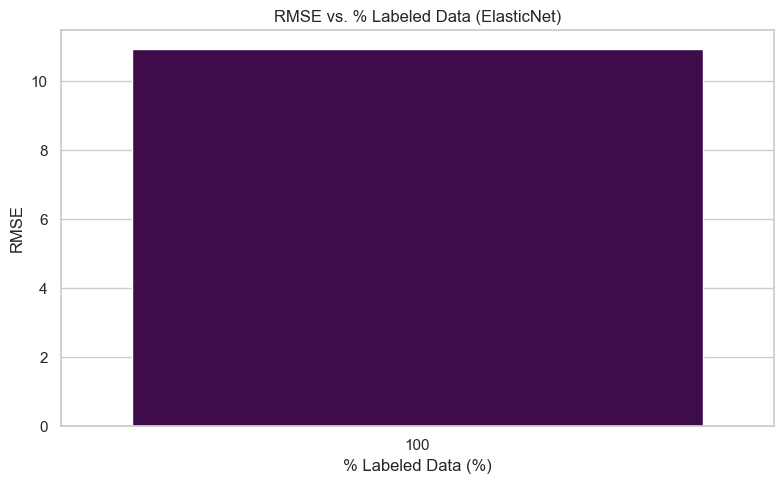

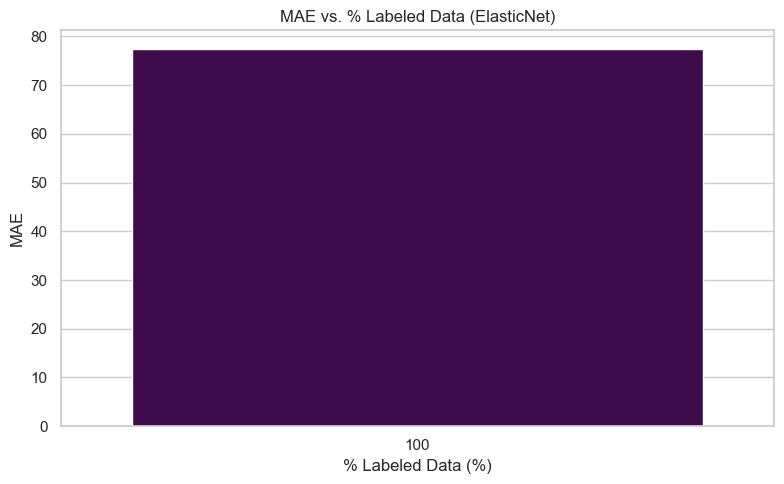

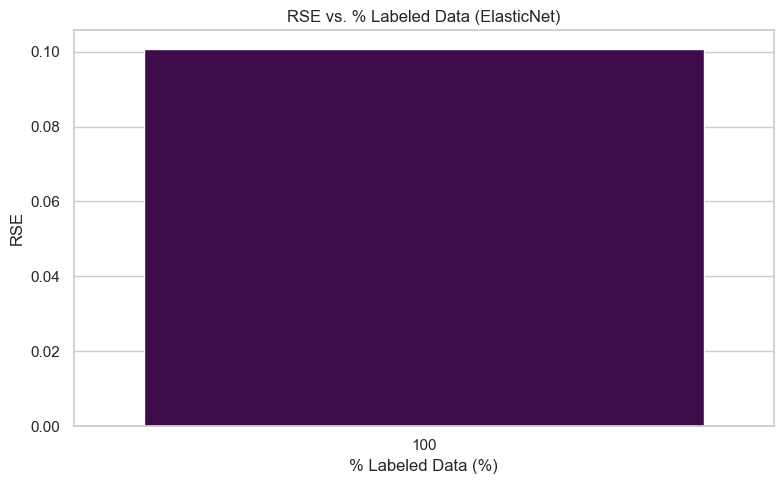

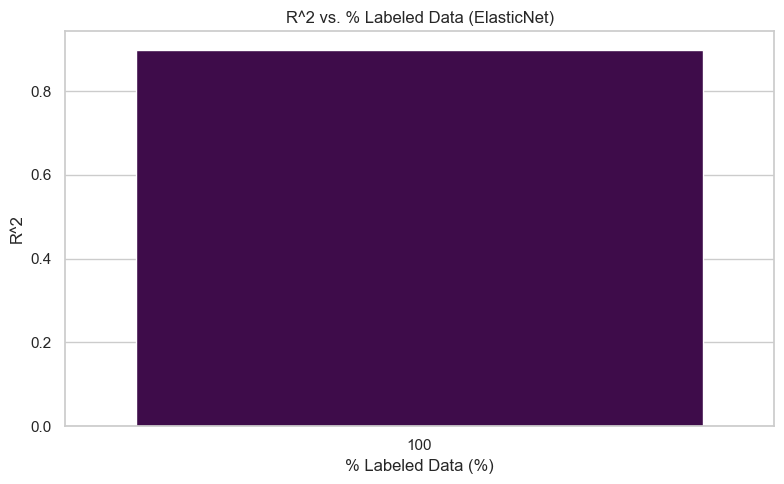

In [24]:
summary_df = results_df.groupby("scale").agg(
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    mae_mean=("mae", "mean"),
    mae_std=("mae", "std"),
    rse_mean=("rse", "mean"),
    rse_std=("rse", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std")
).reset_index()

def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x="scale",
        y=f"{metric}_mean",
        hue="scale",
        data=df,
        palette="viridis",
        legend=False
    )
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. % Labeled Data (ElasticNet)")
    plt.xlabel("% Labeled Data (%)")
    plt.tight_layout()
    plt.show()

plot_metric(summary_df, "rmse", "RMSE")
plot_metric(summary_df, "mae", "MAE")
plot_metric(summary_df, "rse", "RSE")
plot_metric(summary_df, "r2", "R^2")